In [1]:
import os
import argparse
import torch
import math
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn


%load_ext autoreload
%autoreload 1

%aimport SignDataLoad, ganSigns 


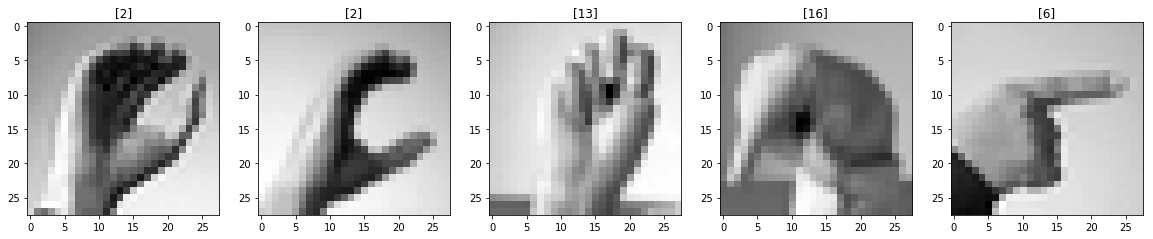

In [23]:
fig = plt.figure(figsize=(20,20))
for show in range(5):
    ax = fig.add_subplot(1,5,show+1)
    num = np.random.choice(100,1)
    im = construct_image(images.loc[num].values)
    ax.imshow(im, cmap='gray')
    plt.title(str(label.loc[num].values))

#crop nes data set
# try to increase resolution (interpolation) 
# train with MNIST (2 classes) - check if it works - write email

In [9]:
#Parameters
parameters={
'n_epochs': 100, #number of epochs of training
'batch_size': 300, #size of the batches
"lr":0.0001, #adam: learning rate
'b1': 0.9, #adam: decay of first order momentum of gradient
'b2':0.999, #adam: decay of first order momentum of gradient
'latent_dim': 100, #dimensionality of the latent space
'n_classes': 6, #number of classes for dataset
'img_size': 28, #size of each image dimension
'channels': 1, #number of image channels
'sample_interval': 10000, # 'interval between image sampling'
'd_steps': 5, # train discriminator
'g_steps': 1 # train generator

}

In [10]:
# Configure data loader
dataset = SignDataLoad.DataSigns()
dataloader = torch.utils.data.DataLoader(
    dataset = dataset, batch_size=parameters['batch_size'], shuffle=True)

In [13]:

cuda = True if torch.cuda.is_available() else False

# Initialize generator and discriminator
generator = ganSigns.Generator(parameters)
discriminator = ganSigns.Discriminator(parameters)

# Loss functions
adversarial_loss = torch.nn.MSELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=parameters['lr'], betas=(parameters['b1'], parameters['b2']))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=parameters['lr'], betas=(parameters['b1'], parameters['b2']))


if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

        
        

[Epoch 0/100] [Batch 28/29] [D loss: 0.018039] [G loss: 0.966631]
[Epoch 1/100] [Batch 28/29] [D loss: 0.016523] [G loss: 0.808743]
[Epoch 2/100] [Batch 28/29] [D loss: 0.038325] [G loss: 0.734329]
[Epoch 3/100] [Batch 28/29] [D loss: 0.013957] [G loss: 1.112984]
[Epoch 4/100] [Batch 28/29] [D loss: 0.020938] [G loss: 1.170758]
[Epoch 5/100] [Batch 28/29] [D loss: 0.017080] [G loss: 1.105831]
[Epoch 6/100] [Batch 28/29] [D loss: 0.021864] [G loss: 1.306001]
[Epoch 7/100] [Batch 28/29] [D loss: 0.021843] [G loss: 1.108264]
[Epoch 8/100] [Batch 28/29] [D loss: 0.014944] [G loss: 1.084817]
[Epoch 9/100] [Batch 28/29] [D loss: 0.016363] [G loss: 1.178282]
[Epoch 10/100] [Batch 28/29] [D loss: 0.032922] [G loss: 1.033925]
[Epoch 11/100] [Batch 28/29] [D loss: 0.015224] [G loss: 0.959615]
[Epoch 12/100] [Batch 28/29] [D loss: 0.027893] [G loss: 1.029488]
[Epoch 13/100] [Batch 28/29] [D loss: 0.026182] [G loss: 1.117001]
[Epoch 14/100] [Batch 28/29] [D loss: 0.039021] [G loss: 1.224571]
[Epoc

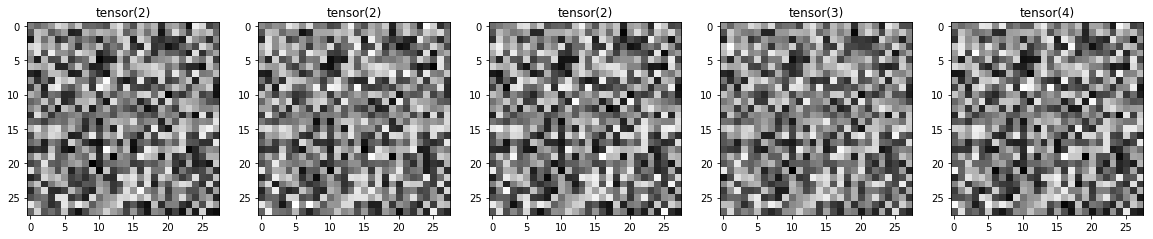

In [14]:
# Training 

for epoch in range(parameters['n_epochs']):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))
        
        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, parameters['latent_dim']))))
        gen_labels = Variable(LongTensor(np.random.randint(0, parameters['n_classes'], imgs.shape[0])))

        
#####################################
        #  Train Discriminator
#####################################
        
#         for train_d in range(parameters['d_steps']):
            
        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

#####################################
        #  Train Generator
#####################################
#         for train_g in range(parameters['g_steps']):
        
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()
        
        
######################################
    # Track training
######################################
        
        batches_done = epoch * len(dataloader) + i
             

        if i==len(dataloader)-1:
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, parameters['n_epochs'], i, len(dataloader),
                                                            d_loss.item(), g_loss.item()))
            generator.G_loss.append(g_loss.item())
            discriminator.D_loss.append(d_loss.item())

        if batches_done % parameters['sample_interval'] == 0:
            # Sample noise and labels as generator input
            z = Variable(FloatTensor(np.random.normal(0, 1, (5, parameters['latent_dim']))))
            labels_check = Variable(LongTensor(np.random.randint(0, parameters['n_classes'], 5)))

            # Generate images
            check_imgs = generator(z, labels_check)
            
            fig = plt.figure(figsize=(20,20))
            for show in range(5):
                ax = fig.add_subplot(1,5,show+1)
                ax.imshow(check_imgs.cpu().detach().numpy()[show,:,:], cmap='gray')
                plt.title(str(labels_check[show].cpu().detach()))

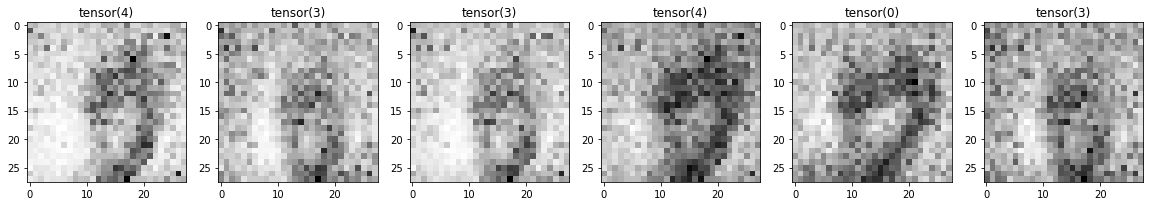

In [7]:
# Sample noise and labels as generator input
z = Variable(FloatTensor(np.random.normal(0, 1, (6, parameters['latent_dim']))))
labels_check = Variable(LongTensor(np.random.randint(0, parameters['n_classes'], 6)))
# Generate images
generator.eval()
check_imgs = generator(z, labels_check)

fig = plt.figure(figsize=(20,20))
for show in range(6):
    ax = fig.add_subplot(1,6,show+1)
    ax.imshow(check_imgs.cpu().detach().numpy()[show,:,:], cmap='gray')
    plt.title(str(labels_check[show].cpu().detach()))

In [ ]:
#Saving the model
torch.save(generator, './generator_linear.pth')
torch.save(generator, './discriminator_linear.pth')



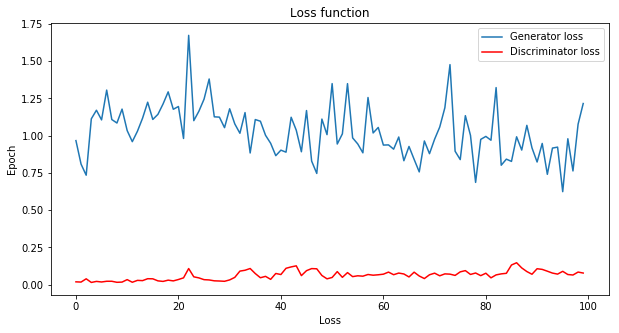

In [15]:
# Print loss function
plt.figure(figsize=(10,5))
plt.plot(generator.G_loss[1:], label='Generator loss')
plt.plot(discriminator.D_loss[1:], c='r', label = 'Discriminator loss')
plt.title('Loss function')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend()